# Text mining 
## Lab 08 Multi-Layer Perceptron on Reuters with reguarization techniques

We are going to train a Neural Network to predict the origin of a document coming from the 20newsgroup dataset.

For this puprose we'll use Tensorflow, and sklearn. Your job is to fill in the missing code into the cells below.

You will find the steps you need to perform in the **Task** section in each cell.

# Homework

## Tasks


0.   Load and preprocess the data for 20newsgroups
1.   Create a multi layer perceptron (MLP) with N hidden layers with ReLU activation, and an Softmax output layer.
2.   Compute it's gradients (manually or using tensorflow's API)
3.   Compile the model with 'categorical_crossentropy' loss, and add metric 'accuracy'
4.   Fill the dropout logic (it must be per layer)
5.   Fill the l2 regularization logic (it must be per layer)
6.   Fill the logic for early stopping
7.   Fix the plotting function plot_history()

## Submission

You must submit your code with experiments:
1. Different number of layers
2. Compare l2, droput and early stopping 
3. Learning curves for train and test metrics (acc, loss) per each experiment

In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups

In [0]:
hparams = tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 50,
    learning_rate = 0.001,
    reg_param = 0.001,
    dropout_keep_prob = 0.8,
    use_dropout = True,
    use_early_stopping = True,
    use_l2_reg = True,
    layers = 5,
    neurons = 64
)

In [0]:
def next_batch(x_, y_, train, batch_size, ids = None):
  if (ids is None):
    # Random sample from the dataset. It can be sequential (but must be shuffled) within epoch, that will guarantee that you'll use all the data.
    # The two approaches are practically equal when using a large number of epochs.
    ids = np.random.choice(x_.shape[0], batch_size, replace=False)
  
  
  feed_dict = {
      x: x_[ids],
      y: y_[ids],
      keep_prob: hparams.dropout_keep_prob if (train) else 1
  }
  
  return feed_dict

  
def evaluate_accuracy(x, y, train):
  return sess.run(accuracy, feed_dict = next_batch(x, y, train, len(x)))

# Data Loading 
We are going to use the 20newsgroup dataset for multi-class text classification with Tensorflow.

First we use the [fetch_20newgroup](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) module from sklearn. 

In [75]:
print('Loading data...')

# Passing none as we want to train over all the data.
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=None)

newsgroups_test = fetch_20newsgroups(subset='test',
                                      categories=None)

Loading data...


# Preprocessing

In this paragraph you need to pre-process your data and create vectors suitable for feeding the NN. You can try different transorfmations and features, TFIDF would be a good start.

You can use:<

1.   [Tokenizer](https://keras.io/preprocessing/text/#tokenizer) from Keras, and to convert the list in newsgrops_\*.data into BOW (Bag-Of-Words) vectors.
2.   Convert the labels to OneHot encoded vectors e.g. for label '2' your vector should look like this [0, 0, ..., 1, 0] helpers can be found [here](https://keras.io/utils/);

## Expected output

20 classes

Vectorizing sequence data...

x_train shape: (11314, max_features)

x_test shape: (7532, max_features)

Convert class vector to binary class matrix (for use with categorical_crossentropy)

y_train shape: (11314, 20)

y_test shape: (7532, 20)

In [123]:
from keras.preprocessing.text import Tokenizer
import keras

num_classes = np.max(newsgroups_train.target) + 1
max_words = 10000

print(num_classes, 'classes')

print('Vectorizing sequence data...')

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(newsgroups_train.data)

x_train = tokenizer.texts_to_matrix(newsgroups_train.data, mode='binary')
x_test = tokenizer.texts_to_matrix(newsgroups_test.data, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')

y_train = keras.utils.to_categorical(newsgroups_train.target, num_classes)
y_test = keras.utils.to_categorical(newsgroups_test.target, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

20 classes
Vectorizing sequence data...
x_train shape: (11314, 10000)
x_test shape: (7532, 10000)
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (11314, 20)
y_test shape: (7532, 20)


# Model building
For the architecture you can refer to the picture below. 

You can find detailed overview of backprop [here](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/).

You can find detailed overview of regularization [here](http://www.deeplearningbook.org/contents/regularization.html).


![alt text](http://paddlepaddle.org/docs/develop/book/02.recognize_digits/image/softmax_regression_en.png)

In [0]:
def weights_and_biases(a, b):
  W = tf.Variable(tf.random_normal([a, b], 0, 0.1))
  b = tf.Variable(tf.zeros([b]))
  return {'W': W, 'b': b}

In [124]:
tf.reset_default_graph()

keep_prob = tf.placeholder_with_default(1.0, shape=())
x = tf.placeholder(tf.float32, shape=(None, max_words))
y = tf.placeholder(tf.float32, shape=(None, num_classes))

layer_config = [max_words] + [hparams.neurons] * (hparams.layers - 1) + [num_classes]
print('layer_config', layer_config)
layers = []

last = x
for i in range(hparams.layers):
  #create layers
  layer = weights_and_biases(layer_config[i], layer_config[i+1])
  layers.append(layer)
  
  if i == hparams.layers - 1:
    # last layer
    out = tf.matmul(last, layer['W']) + layer['b']
  else:  
    layer = tf.nn.relu(tf.matmul(last, layer['W']) + layer['b'])
    if (hparams.use_dropout):
      layer = tf.nn.dropout(layer, keep_prob)
  last = layer

  
# Construct model
pred = tf.nn.softmax(out) # Softmax

# Minimize error using cross entropy
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=out, labels=y))


if (hparams.use_l2_reg):
  # use hparams.reg_param * norm of weights (per layer) and add it to the loss function
  reg = sum([tf.nn.l2_loss(layer['W']) for layer in layers])
  cost = cost + reg * hparams.reg_param

  
optimizer = tf.train.AdamOptimizer(hparams.learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

layer_config [10000, 64, 64, 64, 64, 20]


# Model training

In this section you'll only need to run the cells, you don't have to modify them!

In [0]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
# Start training
sess = tf.Session()
sess.run(init)

In [126]:
history = {
    #First element is train, second is test
    'acc': [[], []],
    'loss': [[], []]
}

best_loss = 100000000
early_stopping_step = 2

# Training cycle
for epoch in range(hparams.max_epochs):
    avg_cost = []
    avg_cost_test = []
    total_batch = x_train.shape[0]//hparams.batch_size
    # Loop over all batches
    for i in range(total_batch):
        feed_dict = next_batch(x_train, y_train, True, hparams.batch_size)
        
        # Fit training using batch data
        _,  c = sess.run([optimizer, cost], feed_dict=feed_dict)

        # Compute average loss
        avg_cost.append(c)        
        train_loss = np.mean(avg_cost)

        
        feed_dict_test = next_batch(x_test, y_test, False, hparams.batch_size)
        c_test = sess.run([cost], feed_dict=feed_dict_test)        
        avg_cost_test.append(c_test)
        test_loss = np.mean(avg_cost_test)

        #For early stopping it is better to evalaute loss and acc per step!
        acc = evaluate_accuracy(x_train, y_train, True)
        test_acc = evaluate_accuracy(x_test, y_test, False)
    
    
    print ("Epoch:", '%04d' % (epoch+1), 
     "| cost=", "{:.9f}".format(train_loss), 
     "| test cost=", "{:.9f}".format(test_loss), 
     "| acc=", "{:.9f}".format(acc),
     "| test_acc=", "{:.9f}".format(test_acc))
        
    if (hparams.use_early_stopping):
      if (test_loss < best_loss):
        stopping_step = 0
        best_loss = test_loss
      else:
        stopping_step += 1
      
      if stopping_step >= early_stopping_step:
        print("Early stopping at step: {}, loss: {}".format(epoch, best_loss))
        break

    history['loss'][0].append(train_loss)
    history['loss'][1].append(test_loss)

    history['acc'][0].append(acc)
    history['acc'][1].append(test_acc)
    
  
print ("Optimization Finished!")

Epoch: 0001 | cost= 3.564546585 | test cost= 3.510908604 | acc= 0.503447056 | test_acc= 0.556425929
Epoch: 0002 | cost= 1.655635715 | test cost= 1.761603475 | acc= 0.753137708 | test_acc= 0.692910254
Epoch: 0003 | cost= 1.200455189 | test cost= 1.535780907 | acc= 0.846826911 | test_acc= 0.733271360
Epoch: 0004 | cost= 0.965664446 | test cost= 1.488478065 | acc= 0.878557563 | test_acc= 0.722915590
Epoch: 0005 | cost= 0.839320123 | test cost= 1.517997265 | acc= 0.907724917 | test_acc= 0.744556546
Epoch: 0006 | cost= 0.783099651 | test cost= 1.512402415 | acc= 0.924783468 | test_acc= 0.746680856
Early stopping at step: 5, loss: 1.4884780645370483
Optimization Finished!


In [0]:
def plot_history(ax, history, metric):
  rng = list(range(1, epoch + 1))
  m, = ax.plot(rng, history[metric][0], 'b', label='Train ' + metric)
  val_m, = ax.plot(rng, history[metric][1], 'r', label='Test ' + metric)
  ax.legend(handles=[m, val_m])
  
  
  ax.set_xlabel('Epoch', fontsize=24)
  ax.set_ylabel(metric, fontsize=24)  

In [0]:
def plot_acc_loss():
  print("Layers:", hparams.layers)
  print("With l2:", hparams.use_l2_reg)
  print("With dropout:", hparams.use_dropout)
  print("With early stopping:", hparams.use_early_stopping)
  fig = plt.figure(figsize=(10,10))

  ax1 = plt.subplot(211)
  ax2 = plt.subplot(212)

  plot_history(ax1, history, 'loss')
  plot_history(ax2, history, 'acc')

#Experiments

Layers: 3
With l2: False
With dropout: False
With early stopping: False


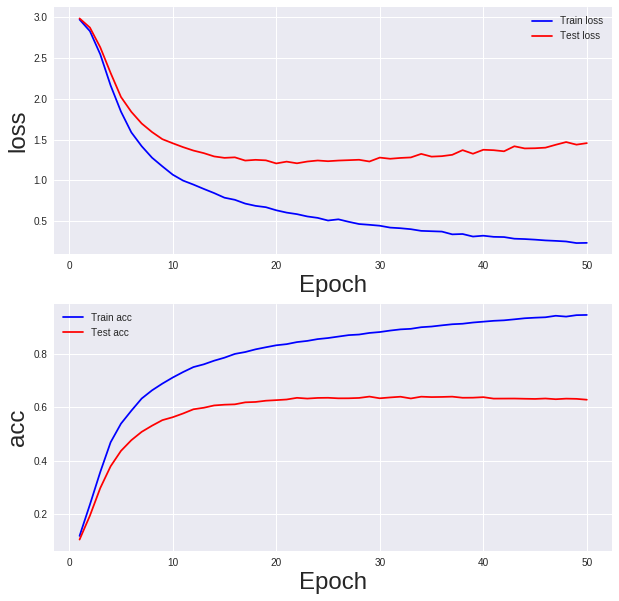

In [95]:
plot_acc_loss()
# 1k max words

Layers: 3
With l2: False
With dropout: False
With early stopping: True


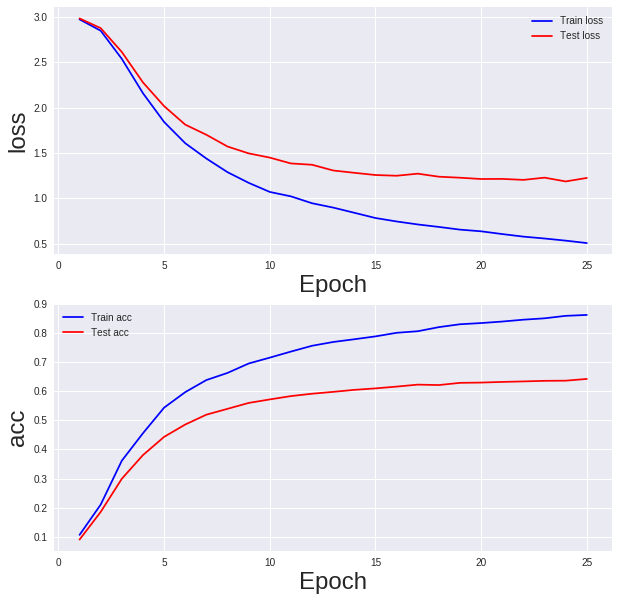

In [101]:
plot_acc_loss()
# 1k max words

Layers: 3
With l2: False
With dropout: True
With early stopping: True


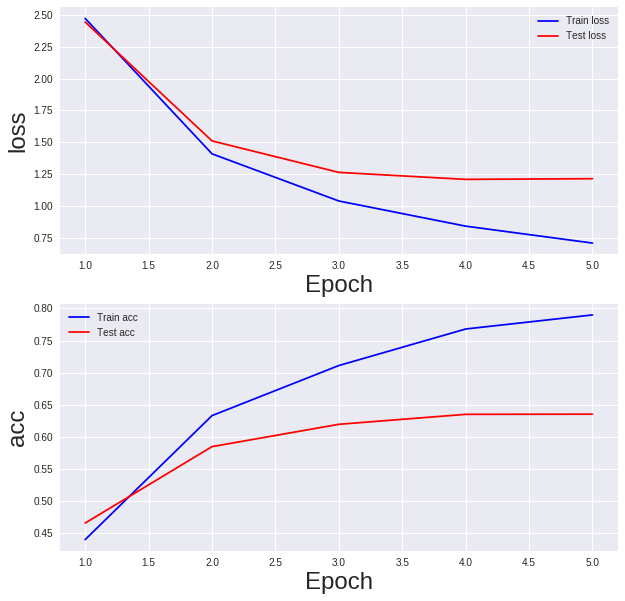

In [117]:
plot_acc_loss()
# 1k max words

In [112]:
plot_acc_loss()
# 1k max words

Layers: 3
With l2: True
With dropout: True
With early stopping: True


Layers: 5
With l2: True
With dropout: True
With early stopping: True


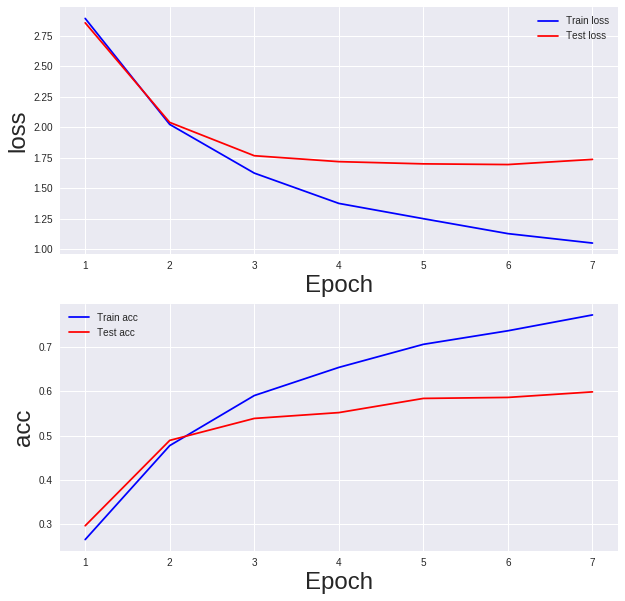

In [122]:
plot_acc_loss()
# 1k max words

In [127]:
plot_acc_loss()
# 10k max words

Layers: 5
With l2: True
With dropout: True
With early stopping: True
